In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
# import xgboost as xgb
from keras import Model
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.regularizers import l2, l1
from imblearn.combine import SMOTETomek
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from keras.layers import (
    Bidirectional,
    LSTM,
    Dense,
    Dropout,
    BatchNormalization,
    Input,
    Activation,
)

## Training Data

In [2]:
df_train = pd.read_csv("./clean_train.csv")
df_train = df_train.replace({True: 1, False:0})
df_train.head()

,Tenure,Matric,Degree,Diploma,Female,Sa_citizen,Birthyear,Birthmonth,Target,Year_survey,...,Home_lang_70_79,Home_lang_80_100,Home_lang_nan,Science_30_39,Science_40_49,Science_50_59,Science_60_69,Science_70_79,Science_80_100,Science_nan
0,0.0,1.0,0.0,0.0,1,1,2000,5,0,2022,...,0,0,1,0,0,0,0,0,0,0
1,427.0,1.0,0.0,0.0,1,1,1989,4,1,2023,...,0,0,1,1,0,0,0,0,0,0
2,0.0,1.0,0.0,0.0,0,1,1996,7,1,2022,...,0,0,1,1,0,0,0,0,0,0
3,810.0,0.0,0.0,0.0,0,1,2000,1,0,2022,...,0,0,1,0,0,0,0,0,0,1
4,0.0,0.0,0.0,0.0,1,1,1998,12,0,2023,...,0,0,1,0,0,0,0,0,0,1


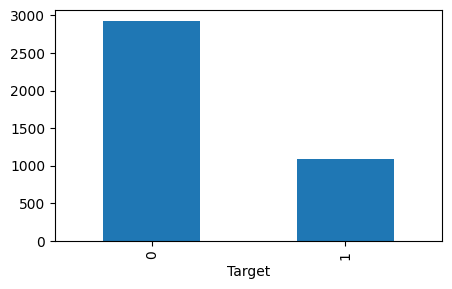

In [3]:
plt.figure(figsize=(5, 3))
df_train['Target'].value_counts().plot(kind='bar')
plt.show()

In [4]:
train = df_train.drop('Target', axis=1)
targets = df_train['Target']

train.shape, targets.shape

((4020, 73), (4020,))

## Class Imbalance

In [5]:
# def min_max_scaling(column):
#     min_val = column.min()
#     max_val = column.max()
#     scaled_column = (column - min_val) / (max_val - min_val)
#     return scaled_column

# # scale all columns [0-1]
# train = train.iloc[:, :].apply(min_max_scaling)
# train.head()

In [6]:
train = train.drop(['Round_nan', 'Status_nan', 'Geography_nan', 'Province_nan'], axis=1)
train.head()

,Tenure,Matric,Degree,Diploma,Female,Sa_citizen,Birthyear,Birthmonth,Year_survey,Age_survey,...,Home_lang_70_79,Home_lang_80_100,Home_lang_nan,Science_30_39,Science_40_49,Science_50_59,Science_60_69,Science_70_79,Science_80_100,Science_nan
0,0.0,1.0,0.0,0.0,1,1,2000,5,2022,22,...,0,0,1,0,0,0,0,0,0,0
1,427.0,1.0,0.0,0.0,1,1,1989,4,2023,34,...,0,0,1,1,0,0,0,0,0,0
2,0.0,1.0,0.0,0.0,0,1,1996,7,2022,26,...,0,0,1,1,0,0,0,0,0,0
3,810.0,0.0,0.0,0.0,0,1,2000,1,2022,22,...,0,0,1,0,0,0,0,0,0,1
4,0.0,0.0,0.0,0.0,1,1,1998,12,2023,25,...,0,0,1,0,0,0,0,0,0,1


In [7]:
# tl_us = TomekLinks(sampling_strategy='majority')
tl_us = SMOTETomek(random_state=42, sampling_strategy = 1.0)
x_resample,y_resample = tl_us.fit_resample(train, targets )
#
x_resample.shape,y_resample.value_counts()

((5714, 69),
 Target
 0    2857
 1    2857
 Name: count, dtype: int64)

Target
0    2857
1    2857
Name: count, dtype: int64


/Users/aapoh/codes/ghp/zindi-piyipc/env-zindi/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aapoh/codes/ghp/zindi-piyipc/env-zindi/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aapoh/codes/ghp/zindi-piyipc/env-zindi/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


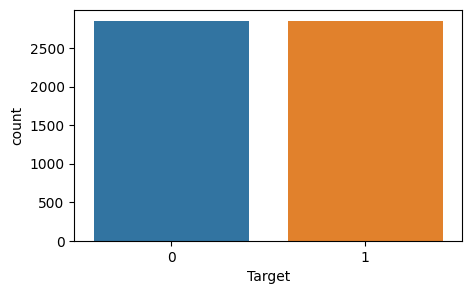

In [8]:
print(y_resample.value_counts())
#
plt.figure(figsize=(5, 3))
sns.countplot(x=y_resample)
plt.show()

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_resample, y_resample, test_size=0.2, random_state=42)
x_train.shape, y_train.shape

((4571, 69), (4571,))

## Test Data

In [10]:
# clean data
test_data = pd.read_csv("./clean_test.csv")
test_data = test_data.replace({True: 1, False:0})
test_data.head()

,Tenure,Matric,Degree,Diploma,Female,Sa_citizen,Birthyear,Birthmonth,Year_survey,Age_survey,...,Home_lang_70_79,Home_lang_80_100,Home_lang_nan,Science_30_39,Science_40_49,Science_50_59,Science_60_69,Science_70_79,Science_80_100,Science_nan
0,0.0,1.0,0.0,0.0,0,1,2002,12,2022,20,...,0,0,1,0,1,0,0,0,0,0
1,979.0,1.0,0.0,0.0,1,1,1989,12,2023,34,...,0,0,1,0,0,0,0,0,0,1
2,339.0,0.0,0.0,0.0,1,1,1989,12,2023,34,...,0,0,1,0,0,0,0,0,0,1
3,0.0,1.0,0.0,0.0,0,1,2002,11,2023,21,...,0,0,1,0,0,0,0,0,0,1
4,613.0,0.0,0.0,0.0,1,1,1993,10,2023,30,...,0,0,1,0,0,0,0,0,0,1


In [11]:
test_data = test_data.drop(['Round_nan', 'Status_nan', 'Geography_nan', 'Province_nan'], axis=1)
test_data.head()

,Tenure,Matric,Degree,Diploma,Female,Sa_citizen,Birthyear,Birthmonth,Year_survey,Age_survey,...,Home_lang_70_79,Home_lang_80_100,Home_lang_nan,Science_30_39,Science_40_49,Science_50_59,Science_60_69,Science_70_79,Science_80_100,Science_nan
0,0.0,1.0,0.0,0.0,0,1,2002,12,2022,20,...,0,0,1,0,1,0,0,0,0,0
1,979.0,1.0,0.0,0.0,1,1,1989,12,2023,34,...,0,0,1,0,0,0,0,0,0,1
2,339.0,0.0,0.0,0.0,1,1,1989,12,2023,34,...,0,0,1,0,0,0,0,0,0,1
3,0.0,1.0,0.0,0.0,0,1,2002,11,2023,21,...,0,0,1,0,0,0,0,0,0,1
4,613.0,0.0,0.0,0.0,1,1,1993,10,2023,30,...,0,0,1,0,0,0,0,0,0,1


In [12]:
# test_data = test_data.iloc[:, :].apply(min_max_scaling)
# test_data.head()

## Models

#### Naive Bayes Gaussian

In [13]:
# # NB
# grid_search_params = {"var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

# cls_gnb = GaussianNB()

# grid_search = GridSearchCV(
#     estimator=cls_gnb, param_grid=grid_search_params, cv=10, scoring="accuracy"
# )

# grid_search.fit(x_train, y_train)

# print(f"{grid_search.best_params_}\n\n")
# print(f"{grid_search.best_estimator_}")

In [14]:
# # perform cross val on data
# model = GaussianNB(var_smoothing=1e-07)
# cv = StratifiedKFold(random_state=42, n_splits=10, shuffle=True)
# scores = cross_val_score(model, x_train, y_train, cv=cv, scoring='accuracy')
# print(f"mean score: {scores.mean()}")

In [15]:
# model.fit(x_train, y_train)

#### SVM - SVC - Slow

In [16]:
# # svc takes times
# # "C": [0.08, 0.05, 0.03, 0.01, 0.1, 1, 3, 5, 7, 10],
# grid_search_params = {
#     "C": [0.01, 0.05, 0.1, 1, 5, 10],
#     "kernel": ["linear", "rbf", "poly", "sigmoid"],
#     "degree": [2, 3, 4, 5],
#     "gamma": ["scale", "auto"] + [0.001, 0.01, 0.1, 1],
# }

# cls_svc = SVC()

# grid_search = GridSearchCV(
#     estimator=cls_svc, param_grid=grid_search_params, cv=5, scoring="accuracy"
# )

# grid_search.fit(x_train, y_train)

# print(f"{grid_search.best_params_}\n\n")
# print(f"{grid_search.best_estimator_}")

In [17]:
# # perform cross val on data
# model = SVC()
# cv = StratifiedKFold(random_state=42, n_splits=10, shuffle=True)
# scores = cross_val_score(model, x_train, y_train, cv=cv, scoring='accuracy')
# print(f"mean score: {scores.mean()}")

In [18]:
# model.fit(x_train, y_train)

#### Deep Learning

In [19]:
# # x_train.reshape(x_train.shape[0], 23, 3)
# x_train = np.array(x_train).reshape(x_train.shape[0], 23, 3)

In [20]:
# # remove province nan
# dl_data = np.array( train.drop('Province_nan', axis=1)).astype(np.float32)
# dl_data = dl_data.reshape(dl_data.shape[0], 9, -1 )
# dl_data.shape 

In [21]:
# x_test = np.array(x_test).reshape(x_test.shape[0], 23, 3)
# y_test = np.asarray(y_test).astype('int').reshape((-1,1))
# x_test.shape, y_test.shape

In [22]:
# y_train = np.array(y_train)
# y_train

In [23]:
# input_shape = x_train.shape[1: ]

# input_layer = Input(shape=input_shape)

# # units = [256, 128, 64, 32]
# # x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=(l2(0.01)) ))(input_layer)
# x = LSTM(128, return_sequences=True, kernel_regularizer=(l2(0.01)))(input_layer)
# # x = BatchNormalization()(x)
# x = Activation("relu")(x)
# x = Dropout(0.5)(x)
# #
# # x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=(l2(0.01))))(x)
# # # x = LSTM(32, return_sequences=True, kernel_regularizer=(l2(0.01)))(x)
# # # x = BatchNormalization()(x)
# # x = Activation("relu")(x)
# # x = Dropout(0.5)(x)
# #
# # x = Bidirectional(LSTM(16, return_sequences=True, kernel_regularizer=(l2(0.01))))(x)
# # # x = LSTM(16, return_sequences=True, kernel_regularizer=(l2(0.01)))(x)
# # # x = BatchNormalization()(x)
# # x = Activation("relu")(x)
# # x = Dropout(0.5)(x)

# output_layer = Dense(1, activation="sigmoid")(x)

# model = Model(inputs=input_layer, outputs=output_layer)

# #
# learning_rate = 0.01
# optim_ = Adam(learning_rate=learning_rate)

# #

# model.compile(optimizer=optim_, loss="binary_crossentropy", metrics=["accuracy"],)

# model.summary()

In [24]:
# y_train = np.asarray(y_train).astype('int').reshape((-1,1))
# x_train.shape, y_train.shape

In [25]:
# epochs= 10
# batch_size = 32
# class_weights = {0: 1.0, 1: 1.5}
# model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

In [26]:
# # remove province nan
# dl_test_data = np.array( test_data.drop('Province_nan', axis=1)).astype(np.float32)
# dl_test_data = dl_test_data.reshape(dl_test_data.shape[0], 9, -1 )
# dl_test_data.shape

# y_pred = model.predict(dl_test_data)

In [27]:
# # y_pred = np.squeeze(y_pred)
# # predictions= ( y_pred >= .5).astype('int')[:,0]
# # predictions
# test_data = np.array(test_data).reshape(test_data.shape[0], 23, 3)
# test_data.shape

#### Multinomial NB

In [28]:
# # NB
# grid_search_params = {
#     "alpha": [0.1, 0.5, 1.0, 2.0],
#     "fit_prior": [True, False],
# }

# cls_mnb = MultinomialNB()

# grid_search = GridSearchCV(
#     estimator=cls_mnb, param_grid=grid_search_params, cv=30, scoring="accuracy"
# )

# grid_search.fit(x_train, y_train)

# print(f"Best Params: {grid_search.best_params_}")
# print(f"Best Estimator: {grid_search.best_estimator_}")
# print(f"Best Score: {grid_search.best_score_}")

In [29]:
# model = MultinomialNB(alpha=0.1, fit_prior=True )
# model.fit(x_train, y_train)

In [30]:
# predictions = cls_mnb.predict(test_data)
# predictions

#### Random Forest Classifier

In [31]:
# grid_search_params = {
#     'n_estimators': [50, 100, 200],  # Number of trees in the forest
#     'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
#     'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for the best split
# }

# cls_rf = RandomForestClassifier(random_state=42)

# grid_search = GridSearchCV(
#     estimator=cls_rf, param_grid=grid_search_params, cv=10, scoring="accuracy"
# )

# grid_search.fit(x_train, y_train)

# print(f"{grid_search.best_params_}\n\n")
# print(f"{grid_search.best_estimator_}")

In [32]:
# model = RandomForestClassifier(
#     random_state=42,
#     max_features="sqrt",
#     max_depth=None,
#     min_samples_leaf=1,
#     min_samples_split=5,
#     n_estimators=200,
# )

model = RandomForestClassifier(min_samples_split=5, n_estimators=200, random_state=42)

cv = StratifiedKFold(random_state=42, n_splits=10, shuffle=True)

scores = cross_val_score(model, x_train, y_train, cv=cv, scoring="accuracy")

print(f"mean score: {scores.mean()}")

mean score: 0.8801128491299819


In [33]:
model.fit(x_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=200, random_state=42)

#### KNN

In [34]:
# grid_search_params = {
#     "n_neighbors": [3, 5, 7, 9],
#     "weights": ["uniform", "distance"],
#     "p": [1, 2],
#     # "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
# }

# cls_knn = KNeighborsClassifier()

# grid_search = GridSearchCV(
#     estimator=cls_knn, param_grid=grid_search_params, cv=10, scoring="accuracy"
# )

# grid_search.fit(train, targets)

# # print(f"{grid_search.best_params_}\n\n")
# print(f"{grid_search.best_estimator_}")

In [35]:
# knn = KNeighborsClassifier( n_neighbors=5, weights="distance", p=2 )

# cv = StratifiedKFold(random_state=42, n_splits=10, shuffle=True)

# scores = cross_val_score(knn, train, targets, cv=cv, scoring='accuracy')

# print(f"mean score: {scores.mean()}")

In [36]:
# knn.fit(train, targets)
# predictions = knn.predict(test_data)
# predictions

#### DecisionTreeClassifier

In [37]:
# grid_search_params = {
#     "criterion": ["gini", "entropy"],
#     "max_depth": [None, 5, 10, 15, 20],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4],
# }

# cls_dt = DecisionTreeClassifier()

# grid_search = GridSearchCV(
#     estimator=cls_dt, param_grid=grid_search_params, cv=10, scoring="accuracy"
# )

# grid_search.fit(train, targets)

# print(f"{grid_search.best_params_}\n\n")
# print(f"{grid_search.best_estimator_}")

In [38]:
# dt = DecisionTreeClassifier(
#     criterion="gini", max_depth=10, min_samples_leaf=4, min_samples_split=5
# )
# # dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5)

# cv = StratifiedKFold(random_state=42, n_splits=10, shuffle=True)

# scores = cross_val_score(dt, train, targets, cv=cv, scoring="accuracy")

# print(f"mean score: {scores.mean()}")

In [39]:
# dt.fit(train, targets)
# predictions = dt.predict(test_data)
# predictions

#### SGDClassifier

In [40]:
# grid_search_params = {
#     "loss": ["hinge", "log", "modified_huber"],
#     "penalty": ["none", "l1", "l2", "elasticnet"],
#     "alpha": [0.0001, 0.001, 0.01, 0.1],
#     "max_iter": [1000, 2000, 3000],
# }

# cls_sdg = SGDClassifier()

# grid_search = GridSearchCV(
#     estimator=cls_sdg, param_grid=grid_search_params, cv=10, scoring="accuracy"
# )

# grid_search.fit(train, targets)

# # # print(f"{grid_search.best_params_}\n\n")
# # print(f"{grid_search.best_estimator_}")

In [41]:
# sgd = SGDClassifier(alpha=0.001, loss='modified_huber', max_iter=3000,penalty='elasticnet')

# cv = StratifiedKFold(random_state=42, n_splits=10, shuffle=True)

# scores = cross_val_score(sgd, train, targets, cv=cv, scoring='accuracy')

# print(f"mean score: {scores.mean()}")

In [42]:
# sgd.fit(train, targets)
# predictions = sgd.predict(test_data)
# predictions

#### DecisionTreeRegressor

In [43]:
# grid_search_params = {
#     "max_depth": [None, 10, 20, 30],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4],
# }

# cls_dt_reg = DecisionTreeRegressor()

# grid_search = GridSearchCV(
#     estimator=cls_dt_reg, param_grid=grid_search_params, cv=10, scoring="accuracy"
# )

# grid_search.fit(train, targets)

# print(f"{grid_search.best_params_}\n\n")
# print(f"{grid_search.best_estimator_}")

In [44]:
# dt_reg = DecisionTreeRegressor()
# # dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5)

# cv = StratifiedKFold(random_state=42, n_splits=10, shuffle=True)

# scores = cross_val_score(dt_reg, train, targets, cv=cv, scoring="accuracy")

# print(f"mean score: {scores.mean()}")

In [45]:
# dt.fit(train, targets)
# predictions = dt.predict(test_data)
# predictions

#### MLPClassifier

In [46]:
# grid_search_params = {
#     "hidden_layer_sizes": [(64,), (128,), (256,)],
#     "activation": ["relu", "tanh"],
#     "alpha": [0.0001, 0.001, 0.01],
# }


# cls_mlp = MLPClassifier()

# grid_search = GridSearchCV(
#     estimator=cls_mlp, param_grid=grid_search_params, cv=10, scoring="accuracy"
# )

# grid_search.fit(train, targets)

# print(f"{grid_search.best_params_}\n\n")
# print(f"{grid_search.best_estimator_}")

In [47]:
# # mlp = MLPClassifier(alpha=0.01, hidden_layer_sizes=(64,))
# mlp = MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=(256,), random_state=1)
# # mlp = MLPClassifier()

# cv = StratifiedKFold(random_state=42, n_splits=10, shuffle=True)

# scores = cross_val_score(mlp, train, targets, cv=cv, scoring="accuracy")

# print(f"mean score: {scores.mean()}")

In [48]:
# mlp.fit(train, targets)
# predictions = mlp.predict(test_data)
# predictions

## Model Evaluation

In [49]:
y_preds = model.predict(x_test)

In [50]:
y_preds.shape, y_test.shape

((1143,), (1143,))

In [51]:
f1_score(y_test, y_preds)

0.8660550458715597

In [52]:
print(classification_report(y_test, y_preds, zero_division=1))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       584
           1       0.89      0.84      0.87       559

    accuracy                           0.87      1143
   macro avg       0.87      0.87      0.87      1143
weighted avg       0.87      0.87      0.87      1143



In [53]:
cm = confusion_matrix(y_test, y_preds)
cm

array([[525,  59],
       [ 87, 472]])

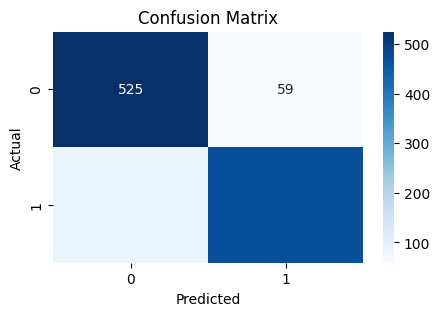

In [54]:
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Save to file

In [55]:
# test_data.shape

In [56]:
predictions = model.predict(test_data)
# predictions = ( predictions >= .5).astype('int')[:,0]
# predictions = predictions.flatten()
predictions

array([1, 0, 0, ..., 0, 0, 0])

In [57]:
# # unclean data
submit_sample = pd.read_csv("./SampleSubmission.csv")
submit_sample.head()

,Person_id,Target
0,Id_r90136smvl,
1,Id_wawdqhmu6s,
2,Id_ap2czff2bu,
3,Id_uhgink7iha,
4,Id_5j6bzk3k81,


In [58]:
df_submission = pd.DataFrame({"Person_id": submit_sample["Person_id"], "Target": predictions.astype(int)})
df_submission.head()

,Person_id,Target
0,Id_r90136smvl,1
1,Id_wawdqhmu6s,0
2,Id_ap2czff2bu,0
3,Id_uhgink7iha,0
4,Id_5j6bzk3k81,0


In [59]:
df_submission.to_csv("submission.csv", index=False)